In [4]:
#importing all necessary libraries
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import collections

import matplotlib.pyplot as plt
import seaborn


Importing Dataset

In [5]:
#reading dataset from csv file
jazz_dataset = pd.read_csv("audio_features_df.csv", index_col=False)
jazz_dataset.head()


,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,timesig,popularity,duration_ms,year_released
0,3cuOpppX5ZNOQ843dPeFB4,0.701,0.444,10,-10.272,1,0.0358,0.898,0.000003,0.260,0.8430,126.401,4,44,172773,1964
1,6a5XgyiyTG5Ok7cZ1LMLGh,0.149,0.111,4,-24.803,0,0.0333,0.725,0.647000,0.071,0.0326,82.399,4,11,346333,1978
2,4ZVZBc5xvMyV3WzWktn8i7,0.807,0.497,7,-10.656,1,0.0297,0.306,0.032300,0.043,0.7650,114.523,4,65,141506,1969
3,1Y5YesFGgIlV7SnfE13G8k,0.515,0.205,7,-17.959,0,0.0369,0.871,0.033900,0.147,0.4520,80.970,4,2,325611,1990
4,29U7stRjqHU6rMiS8BfaI9,0.271,0.165,5,-20.652,1,0.0351,0.729,0.000002,0.118,0.2030,77.082,4,68,139226,1968


In [6]:

# to drop any rows that are not useful in our analysis
jazz_dataset.drop(jazz_dataset[jazz_dataset['year_released'] == 0].index, inplace = True)

#changing all songs from before the 1940s to the 1940s to account for outliers
jazz_dataset.loc[jazz_dataset['year_released'] < 1940, 'year_released'] = 1940



In [7]:
#to get a standardized data set to use whenever we are running new models

#creating a method to initialize data
def scale_data(dataset, scalar = StandardScaler()):
    # prepare features 
    data = dataset.copy()
    #initialize an empty target list to store values while we scale the features
    target = []
    #iterate through all target values
    for year in data['year_released']:
        #take the first 2 digits (these tell us the century)
        decade = int(str(year)[:2])
        #append these values to our temporary target value list
        if decade == 19:
            target.append(0)
        else:
            target.append(1)
    
    #drop unnecessary columns, year_released to be added later as 'decade'
    data = data.drop(['track_id','year_released'], axis=1)

    #scale features
    columns = data.columns
    scaled_features = scalar.fit_transform(data)
    scaled_dataset = pd.DataFrame(scaled_features, columns= columns)
    #add the target values back to finalize our dataset
    scaled_dataset['century'] = target

    return scaled_dataset



In [8]:
#getting resulting a scaled dataset of centuries for binary classification task
scaled_jazz_dataset_binary = scale_data(jazz_dataset)

scaled_jazz_dataset_binary.head()


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,timesig,popularity,duration_ms,century
0,1.034887,0.140746,1.395394,0.545107,0.850204,-0.381094,0.911636,-0.903755,0.608759,1.355119,0.415654,0.278752,0.559906,-0.797792,0
1,-2.601239,-1.268976,-0.325281,-2.437394,-1.176188,-0.426385,0.381263,0.787265,-0.656529,-1.828083,-1.099670,0.278752,-1.412387,0.373163,0
2,1.733129,0.365116,0.535056,0.466291,0.850204,-0.491605,-0.903283,-0.819344,-0.843979,1.048740,0.006604,0.278752,1.815002,-1.008741,0
3,-0.190329,-0.871037,0.535056,-1.032657,-1.176188,-0.361166,0.828861,-0.815162,-0.147736,-0.180705,-1.148881,0.278752,-1.950285,0.233358,0
4,-1.797602,-1.040372,-0.038502,-1.585397,0.850204,-0.393776,0.393526,-0.903760,-0.341881,-1.158762,-1.282775,0.278752,1.994301,-1.024123,0


Preliminary Data Exploration

distribution count for each century:
1900s: 10622
2000s: 9444




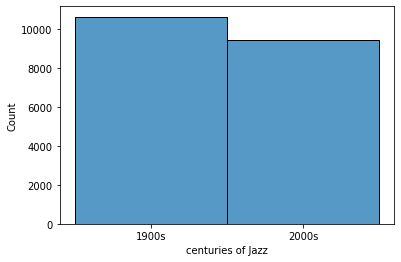

In [9]:
#to show the distribution of the decades for our data exploration

#init empty list to store decadesimport collections
centuries = []

#iterate through each value in our target column 
for year in jazz_dataset['year_released']:
    #extract the century
    century = str(int(str(year)[:2])) + '00s'
    centuries.append(century)

#count frequency of each item 
counter=collections.Counter(centuries)

print('distribution count for each century:')
for key in counter.items():
    print(f'{key[0]}: {key[1]}')

print('\n')

dis = pd.Series(centuries, name="centuries of Jazz")
ax = sns.histplot(data=dis)


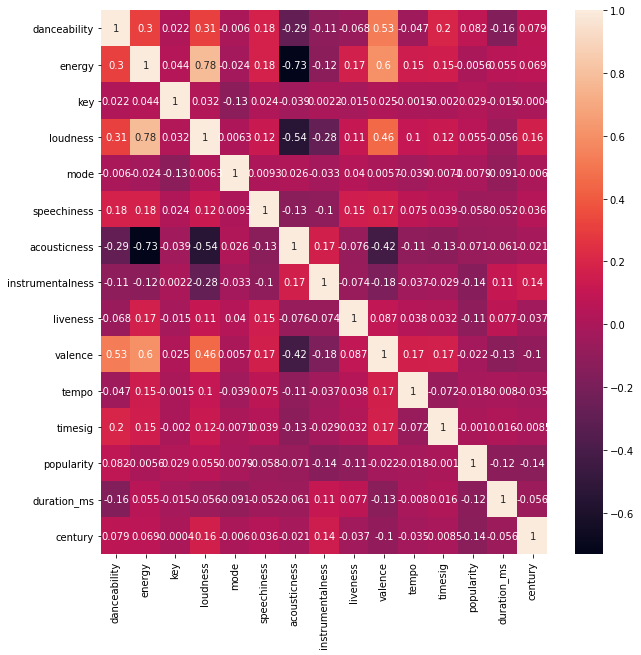

In [10]:
#to plot a correlation matrix

fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(scaled_jazz_dataset_binary.corr(), annot=True, ax=ax)
plt.show()

In [11]:
#prepping data for modeling
from sklearn.model_selection import train_test_split

#prepping features
x = scaled_jazz_dataset_binary.drop(['century'], axis=1)


#prepping target
y = scaled_jazz_dataset_binary['century']


#shuffling the dataset and
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, shuffle= True)


In [15]:
# importing the necessary packages
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    plot_roc_curve
)

logistic regression model

In [16]:
from sklearn.linear_model import LogisticRegressionCV


In [ ]:
#to implement multi-class logistic regression w/ CV 

log_model = LogisticRegressionCV(cv = 5)

log_model.fit(x_train, y_train)

#to make predictions for the testing set
y_test_pred = log_model.predict(x_test)

#display metrics for prediction result
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_F1_score = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, log_model.predict_proba(x_test)[:,1])

#to make predictions for the testing set
y_train_pred = log_model.predict(x_train)

#display metrics for prediction result
train_accuracy = accuracy_score(y_train, y_train_pred)
train_error = (1 - train_accuracy)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_F1_score = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, log_model.predict_proba(x_train)[:,1])


print(f"""Testing Results:
--------------------------
Accuracy: {test_accuracy}
Error: {test_error}
Precision: {test_precision}
Recall: {test_recall}
F1 Score: {test_F1_score}
AUC: {test_auc}
""")

print(f"""Training Results:
--------------------------
Accuracy: {train_accuracy}
Error: {train_error}
Precision: {train_precision}
Recall: {train_recall}
F1 Score: {train_F1_score}
AUC: {train_auc}
""")


# creating a ROC Curve to display
ax = plt.gca()
plot_roc_curve(log_model, x_test, y_test, ax=ax)

# creating a confusion matrix to display
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Confusion Matrix'
plt.title(all_sample_title, size = 15);


k-nearest neighbors classifier

In [30]:
# training a KNN classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

optimal value for K: 3


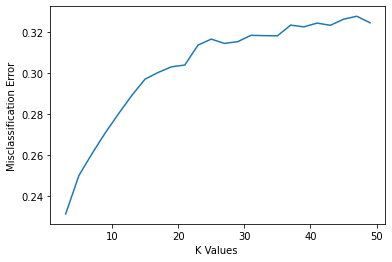

In [31]:
#to select the optimal value of K using cross validation (skipping k=1)
neighbors = [x for x in range(3,50,2)]
# empty list that will hold cv scores
cv_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    
#misclassification error
MSE = [1-x for x in cv_scores]
#optimal K
optimal_k_index = MSE.index(min(MSE))
optimal_k = neighbors[optimal_k_index]
print(f'optimal value for K: {optimal_k}')

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('K Values ')
plt.ylabel('Misclassification Error')
plt.show()

Testing Results:
--------------------------
Accuracy: 0.7775563085509268
Error: 0.22244369144907317
Precision: 0.7671629445822994
Recall: 0.7703488372093024
F1 Score: 0.7687525901367592
AUC: 0.8432711677823633

Training Results:
--------------------------
Accuracy: 0.8857066914745165
Error: 0.11429330852548347
Precision: 0.8767006802721088
Recall: 0.8791927231381467
F1 Score: 0.8779449332954867
AUC: 0.9615031841024111



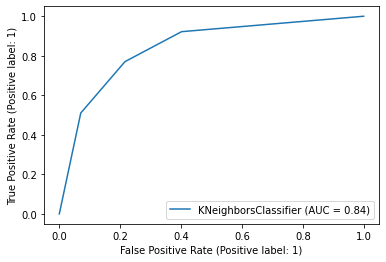

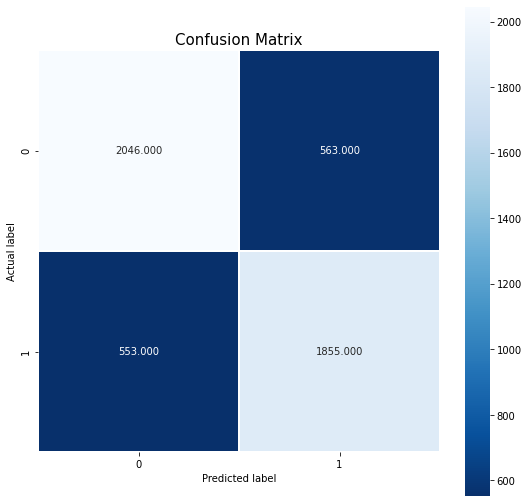

In [33]:
#initializing the KNN model
knn_model = KNeighborsClassifier(n_neighbors = 3)

#fitting the model
knn_model.fit(x_train, y_train)

#to make predictions for the testing set
y_test_pred = knn_model.predict(x_test)

#to get metrics for the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_F1_score = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, knn_model.predict_proba(x_test)[:,1])

#to make predictions for the training set
y_train_pred = knn_model.predict(x_train)

#to get metrics for the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_error = (1 - train_accuracy)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_F1_score = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, knn_model.predict_proba(x_train)[:,1])


print(f"""Testing Results:
--------------------------
Accuracy: {test_accuracy}
Error: {test_error}
Precision: {test_precision}
Recall: {test_recall}
F1 Score: {test_F1_score}
AUC: {test_auc}
""")

print(f"""Training Results:
--------------------------
Accuracy: {train_accuracy}
Error: {train_error}
Precision: {train_precision}
Recall: {train_recall}
F1 Score: {train_F1_score}
AUC: {train_auc}
""")

#creating the ROC curve to display
ax = plt.gca()
plot_roc_curve(knn_model, x_test, y_test, ax=ax)

# creating a confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Confusion Matrix'
plt.title(all_sample_title, size = 15);


Naive Bayes Model

In [34]:
from sklearn.naive_bayes import GaussianNB

Testing Results:
--------------------------
Accuracy: 0.6352401833765199
Error: 0.3647598166234801
Precision: 0.6272007042253521
Recall: 0.5917774086378738
F1 Score: 0.608974358974359
AUC: 0.6921888390429753

Training Results:
--------------------------
Accuracy: 0.6423018140740249
Error: 0.35769818592597513
Precision: 0.6414124694359454
Recall: 0.6423018140740249
F1 Score: 0.6412933600067843
AUC: 0.6959882629612609



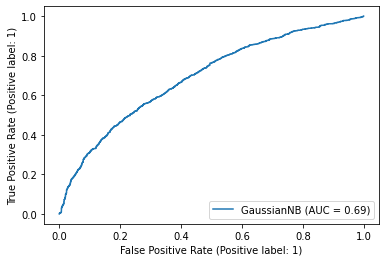

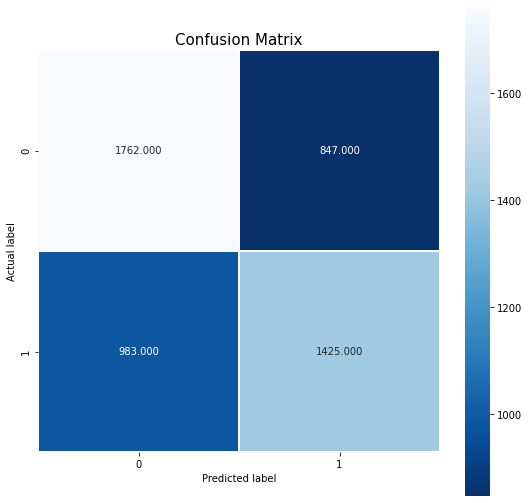

In [35]:

#instantiating the naive bayes model
nb_model = GaussianNB()

nb_model.fit(x_train, y_train)

#to make predictions for the testing set
y_test_pred = nb_model.predict(x_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_F1_score = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, nb_model.predict_proba(x_test)[:,1])

#to make predictions for the training set
y_train_pred = nb_model.predict(x_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_error = (1 - train_accuracy)
train_precision = precision_score(y_train, y_train_pred, average= 'weighted')
train_recall = recall_score(y_train, y_train_pred, average= 'weighted')
train_F1_score = f1_score(y_train, y_train_pred, average = 'weighted')
train_auc = roc_auc_score(y_train, nb_model.predict_proba(x_train)[:,1])


print(f"""Testing Results:
--------------------------
Accuracy: {test_accuracy}
Error: {test_error}
Precision: {test_precision}
Recall: {test_recall}
F1 Score: {test_F1_score}
AUC: {test_auc}
""")

print(f"""Training Results:
--------------------------
Accuracy: {train_accuracy}
Error: {train_error}
Precision: {train_precision}
Recall: {train_recall}
F1 Score: {train_F1_score}
AUC: {train_auc}
""")


#creating the ROC curve
ax = plt.gca()
plot_roc_curve(nb_model, x_test, y_test, ax=ax)

# creating a confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Confusion Matrix'
plt.title(all_sample_title, size = 15);


Adaboost classifier

In [36]:
from sklearn.ensemble import AdaBoostClassifier

optimal number of estimators: 100


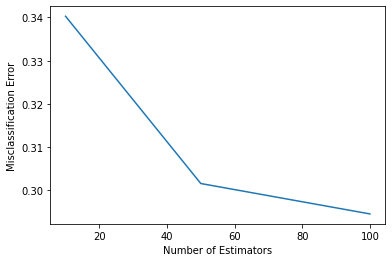

In [37]:
#hyper parameter tuning to select the best number of estimators
n_estimators = [10,50,100]

# empty list that will hold cv scores
cv_scores = []
for val in n_estimators:
    adb = AdaBoostClassifier(n_estimators=val)
    scores = cross_val_score(adb, x, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    

#misclassification error
MSE = [1-x for x in cv_scores]
#optimal K
optimal_val_idx = MSE.index(min(MSE))
optimal_val = n_estimators[optimal_val_idx]
print(f'optimal number of estimators: {optimal_val}')
# plot misclassification error vs k
plt.plot(n_estimators, MSE)
plt.xlabel('Number of Estimators')
plt.ylabel('Misclassification Error')
plt.show()

optimal learning rate: 1


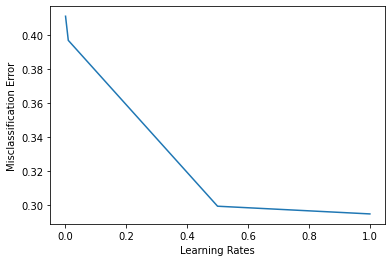

In [38]:
#hyper parameter tuning to select the optimal learning rate
learning_rates = [0.001,0.01,0.5,1]

# empty list that will hold cv scores
cv_scores = []
for l in learning_rates:
    adb = AdaBoostClassifier(n_estimators=100, learning_rate = l)
    scores = cross_val_score(adb, x, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    
#misclassification error
MSE = [1-x for x in cv_scores]
#optimal K
optimal_val_idx = MSE.index(min(MSE))
optimal_val = learning_rates[optimal_val_idx]
print(f'optimal learning rate: {optimal_val}')
# plot misclassification error vs k
plt.plot(learning_rates, MSE)
plt.xlabel('Learning Rates')
plt.ylabel('Misclassification Error')
plt.show()

Testing Results:
--------------------------
Accuracy: 0.7061989236595575
Error: 0.2938010763404425
Precision: 0.7046450482033304
Recall: 0.6677740863787376
F1 Score: 0.6857142857142857
AUC: 0.7804445447588146

Training Results:
--------------------------
Accuracy: 0.7202471925044853
Error: 0.2797528074955147
Precision: 0.71415580478933
Recall: 0.6696986924388857
F1 Score: 0.6912131436115593
AUC: 0.7930484196835629



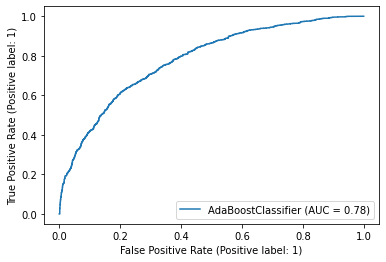

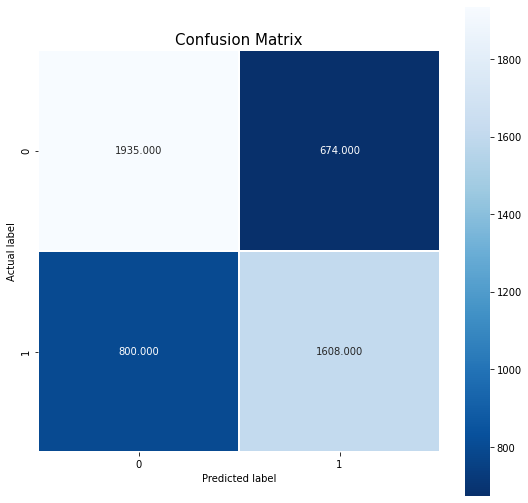

In [39]:
#to implement the adaboost ensemble classifier with 100 weak learners and the default learning_rate = 1 parameter
adb_model = AdaBoostClassifier(n_estimators=100)

#to fit the ensemble model
adb_model.fit(x_train, y_train)

#to make predictions for the testing set
y_test_pred = adb_model.predict(x_test)

#to output metrics for testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_F1_score = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, adb_model.predict_proba(x_test)[:,1])

#to make predictions for the training set
y_train_pred = adb_model.predict(x_train)

#to output metrics for training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_error = (1 - train_accuracy)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_F1_score = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, adb_model.predict_proba(x_train)[:,1])


print(f"""Testing Results:
--------------------------
Accuracy: {test_accuracy}
Error: {test_error}
Precision: {test_precision}
Recall: {test_recall}
F1 Score: {test_F1_score}
AUC: {test_auc}
""")

print(f"""Training Results:
--------------------------
Accuracy: {train_accuracy}
Error: {train_error}
Precision: {train_precision}
Recall: {train_recall}
F1 Score: {train_F1_score}
AUC: {train_auc}
""")


#generate a ROC curve
ax = plt.gca()
plot_roc_curve(adb_model, x_test, y_test, ax=ax)

# creating a confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Confusion Matrix'
plt.title(all_sample_title, size = 15);


Random Forest Classifier

In [40]:
from sklearn.ensemble import RandomForestClassifier

optimal n_learners value: 47


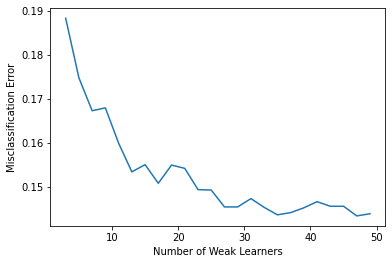

In [41]:
#hyper parameter tuning
n_learners = [x for x in range(3,50,2)]

# empty list that will hold cv scores
cv_scores = []
for n in n_learners:
    rf = RandomForestClassifier(n_estimators=n, criterion='entropy')
    scores = cross_val_score(rf, x, y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
#graphical view
#misclassification error
MSE = [1-x for x in cv_scores]
#optimal K
optimal_n_learners_index = MSE.index(min(MSE))
optimal_n_learners = n_learners[optimal_n_learners_index]
print(f'optimal n_learners value: {optimal_n_learners}')
# plot misclassification error 
plt.plot(n_learners, MSE)
plt.xlabel('Number of Weak Learners')
plt.ylabel('Misclassification Error')
plt.show()

Testing Results:
--------------------------
Accuracy: 0.8626669324297389
Error: 0.1373330675702611
Precision: 0.8467123840258168
Recall: 0.8716777408637874
F1 Score: 0.8590137098424391
AUC: 0.9441887683701574

Training Results:
--------------------------
Accuracy: 1.0
Error: 0.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC: 1.0



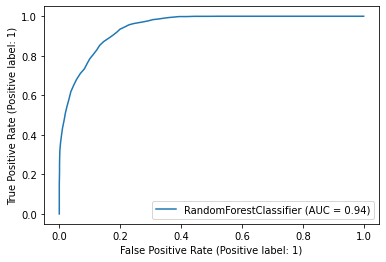

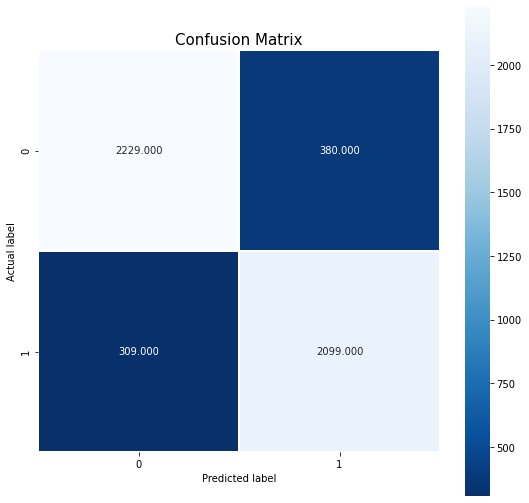

In [42]:
#to implement the random forest classifier with 47 weak learners
rf_model = RandomForestClassifier(n_estimators=47, criterion='entropy')

#fit the model
rf_model.fit(x_train, y_train)

#to make predictions for the testing set
y_test_pred = rf_model.predict(x_test)

#output metrics for testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_F1_score = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, rf_model.predict_proba(x_test)[:,1])

#to make predictions for the training set
y_train_pred = rf_model.predict(x_train)

#output metrics for the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_error = (1 - train_accuracy)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_F1_score = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, rf_model.predict_proba(x_train)[:,1])


print(f"""Testing Results:
--------------------------
Accuracy: {test_accuracy}
Error: {test_error}
Precision: {test_precision}
Recall: {test_recall}
F1 Score: {test_F1_score}
AUC: {test_auc}
""")

print(f"""Training Results:
--------------------------
Accuracy: {train_accuracy}
Error: {train_error}
Precision: {train_precision}
Recall: {train_recall}
F1 Score: {train_F1_score}
AUC: {train_auc}
""")


#generate a ROC curve
ax = plt.gca()
plot_roc_curve(rf_model, x_test, y_test, ax=ax)

# creating a confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Confusion Matrix'
plt.title(all_sample_title, size = 15);


Neural Network

In [43]:
#importing proper libraries and packages 
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network

In [44]:
#developing a simple model with 2 dense and 1 output layer
nn_model = Sequential()

nn_model.add(Dense(8, activation='relu', input_shape=(14,)))

nn_model.add(Dense(8, activation='relu'))

nn_model.add(Dense(1, activation='sigmoid'))


nn_model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

#to fit the model
nn_model.fit(x_train, y_train, epochs=30, batch_size=64, verbose=1)

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpvspqgjvv.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpvspqgjvv.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
236/236 [==============================] - 17s 2ms/step - loss: 0.7128 - accuracy: 0.5139
Epoch 2/30
236/236 [==============================] - 1s 2ms/step - loss: 0.6891 - accuracy: 0.5359
Epoch 3/30
236/236 [==============================] - 0s 2ms/step - loss: 0.6792 - accuracy: 0.5522
Epoch 4/30
236/236 [==============================] - 0s 2ms/step - loss: 0.6713 - accuracy: 0.

Testing Results:
--------------------------
Accuracy: 0.6834761809846522
Error: 0.31652381901534776
Precision: 0.6758147512864494
Recall: 0.654485049833887
F1 Score: 0.6649789029535864
AUC: 0.7458900732068524

Training Results:
--------------------------
Accuracy: 0.690211974217556
Error: 0.309788025782444
Precision: 0.6744049368204525
Recall: 0.6523592950540079
F1 Score: 0.6631989596879064
AUC: 0.7552770629194301



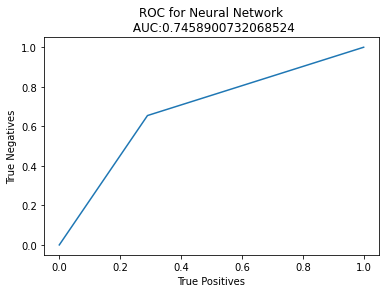

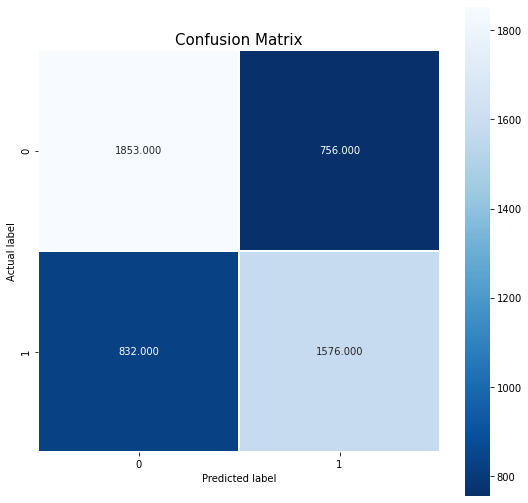

In [45]:

#to make predictions for the testing set
y_test_pred = (nn_model.predict(x_test) > 0.5).astype("int32")

#to ouput model metrics for the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_F1_score = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, nn_model.predict(x_test).ravel())


#to make predictions for the training set
y_train_pred = (nn_model.predict(x_train) > 0.5).astype("int32")

#to ouput model metrics for the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_error = (1 - train_accuracy)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_F1_score = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, nn_model.predict(x_train).ravel())


print(f"""Testing Results:
--------------------------
Accuracy: {test_accuracy}
Error: {test_error}
Precision: {test_precision}
Recall: {test_recall}
F1 Score: {test_F1_score}
AUC: {test_auc}
""")

print(f"""Training Results:
--------------------------
Accuracy: {train_accuracy}
Error: {train_error}
Precision: {train_precision}
Recall: {train_recall}
F1 Score: {train_F1_score}
AUC: {train_auc}
""")

#creating a ROC curve
nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_test_pred)
plt.plot(nn_fpr_keras, nn_tpr_keras)
plt.title(f"ROC for Neural Network\n AUC:{test_auc}")
plt.xlabel("True Positives")
plt.ylabel("True Negatives")


# creating a confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Confusion Matrix'
plt.title(all_sample_title, size = 15);


All ROC Curves

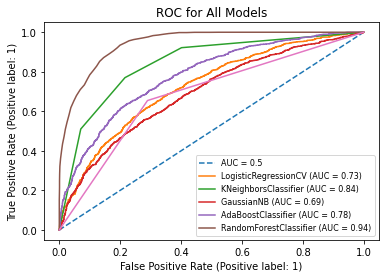

In [50]:
#to show all models on one ROC curve plot
classifiers = [log_model,knn_model, nb_model, adb_model, rf_model]
ax = plt.gca()
plt.plot([0, 1], [0, 1], linestyle='--', label='AUC = 0.5')
plt.title(f"ROC for All Models")

#iterate through the classifiers 
for i in classifiers:
    #display classifier on a plot
    plot_roc_curve(i, x_test, y_test, ax=ax)
plt.plot(nn_fpr_keras, nn_tpr_keras)
    
plt.legend(prop={'size': 8})
plt.show()